In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [33]:
DATA_DIR = "./data"
import os
print(os.path.abspath(DATA_DIR))  

C:\Users\lenovo\course project\data


# Logistic regression models

## Processing of data

In [34]:
# Load data
HCC_Inspections_df = pd.read_csv(f"{DATA_DIR}/HCC_Inspections.csv")
Hourly_Weather_df = pd.read_csv(f"{DATA_DIR}/Hourly_Weather.csv")

# Extract the 'Dew_Point' column and convert it to numeric type
Hourly_Weather_df['Dew_Point'] = pd.to_numeric(
    Hourly_Weather_df['Dew_Point'].str.replace('?', ''), errors='coerce')


## Build a test set

In [35]:
# Build a test set
weather_test = Hourly_Weather_df.head(1000)
inspections_test = HCC_Inspections_df.head(1000)

test_df = pd.DataFrame({
    'Dew_Point': weather_test['Dew_Point'],
    'Healthy': inspections_test['Healthy']
}).dropna()

X_test = test_df[['Dew_Point']]
y_test = test_df['Healthy']

test_df.head()

,Dew_Point,Healthy
0,33.0,No
1,32.0,No
2,32.0,Yes
3,33.0,Yes
4,34.0,No


## Build a test set

In [36]:
# 构建训练集（1000条以后的）
weather_train = Hourly_Weather_df[1000:]
inspections_train = HCC_Inspections_df[1000:]

train_df = pd.DataFrame({
    'Dew_Point': weather_train['Dew_Point'],
    'Healthy': inspections_train['Healthy']
}).dropna()

X_train = train_df[['Dew_Point']]
y_train = train_df['Healthy']

train_df.head()

,Dew_Point,Healthy
1000,58.0,No
1001,59.0,No
1002,64.0,Yes
1003,68.0,Yes
1004,65.0,No


## Standardize data

In [37]:
# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Build a model

In [38]:
# Build logistic regression model
logreg_model = LogisticRegression(random_state=42, max_iter=1000)
logreg_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = logreg_model.predict(X_test_scaled)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f'Model accuracy: {accuracy:.4f}')

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T

# Keep rows: No / accuracy / macro avg / weighted avg
rows_to_keep = ['no', 'accuracy', 'macro avg', 'weighted avg']
filtered_report_df = report_df[report_df.index.str.lower().isin(rows_to_keep)]

print('\nClassification Report (keeping "No", accuracy, macro avg, and weighted avg):')
print(filtered_report_df)


Model accuracy: 0.7540

Classification Report (keeping "No", accuracy, macro avg, and weighted avg):
              precision    recall  f1-score     support
No             0.754793  0.998665  0.859770  749.000000
accuracy       0.754032  0.754032  0.754032    0.754032
macro avg      0.377397  0.499332  0.429885  992.000000
weighted avg   0.569899  0.754032  0.649161  992.000000


## Cross-validation

In [39]:
# Create a Pipeline that includes standardization and logistic regression
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Set up stratified 5-fold cross-validation (maintaining class proportions)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(
    logreg_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring='accuracy'
)

# Print cross-validation results
print("Cross-validation accuracy scores:", cv_scores)
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Train and evaluate the model on the entire training set
logreg_pipeline.fit(X_train, y_train)
y_pred = logreg_pipeline.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest set accuracy: {accuracy:.4f}")

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T

# Keep key metrics
rows_to_keep = ['no', 'accuracy', 'macro avg', 'weighted avg']
filtered_report_df = report_df[report_df.index.str.lower().isin(rows_to_keep)]

print('\nClassification Report:')
print(filtered_report_df)

Cross-validation accuracy scores: [0.55       0.55555556 0.55197133 0.55555556 0.56630824]
Mean CV accuracy: 0.5559 (±0.0056)

Test set accuracy: 0.7540

Classification Report:
              precision    recall  f1-score     support
No             0.754793  0.998665  0.859770  749.000000
accuracy       0.754032  0.754032  0.754032    0.754032
macro avg      0.377397  0.499332  0.429885  992.000000
weighted avg   0.569899  0.754032  0.649161  992.000000


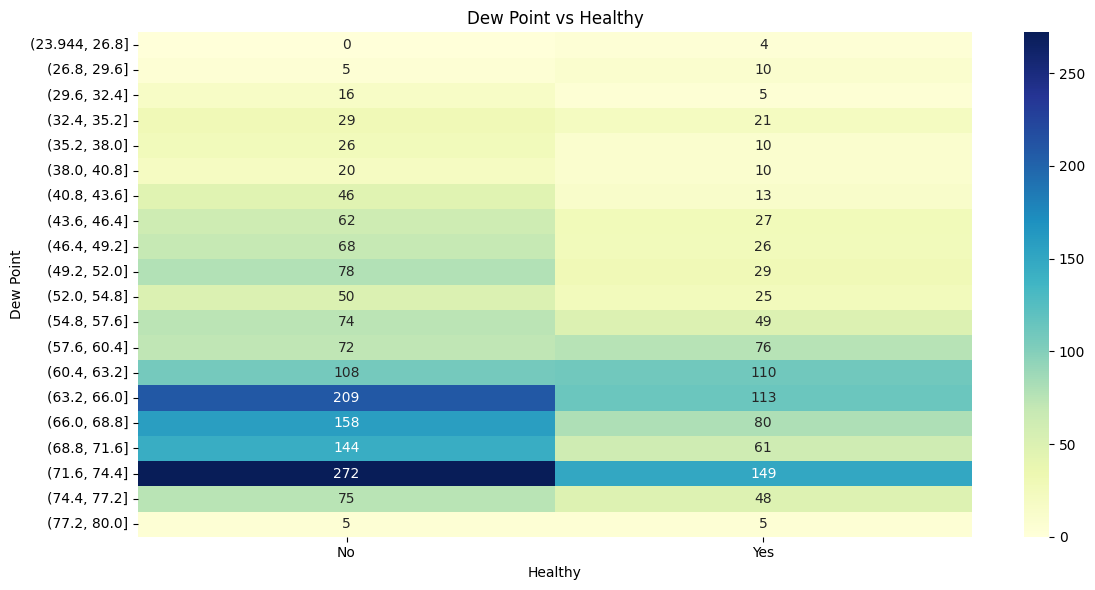

In [40]:
# Merge training and test sets for visualization
full_df = pd.concat([train_df, test_df], axis=0)

# Bin the Dew_Point values
full_df['Dew_Point_Bin'] = pd.cut(full_df['Dew_Point'], bins=20)

# Create a crosstab: count of each Healthy status within each Dew_Point interval
heatmap_data = pd.crosstab(full_df['Dew_Point_Bin'], full_df['Healthy'])

# Optional: Normalize the counts (by row)
# heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Dew Point vs Healthy')
plt.ylabel('Dew Point')
plt.xlabel('Healthy')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


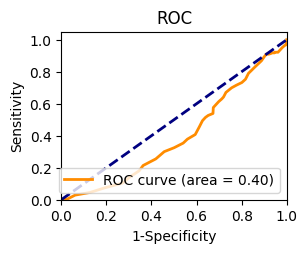

In [42]:
plt.subplot(2, 2, 3)
y_score = logreg_model.predict_proba(X_test_scaled)[:, 1]
# 将真实标签转换为数值类型
y_test_binary = y_test.map({'Yes': 1, 'No': 0})
fpr, tpr, _ = roc_curve(y_test_binary, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC')
plt.legend(loc="lower right")

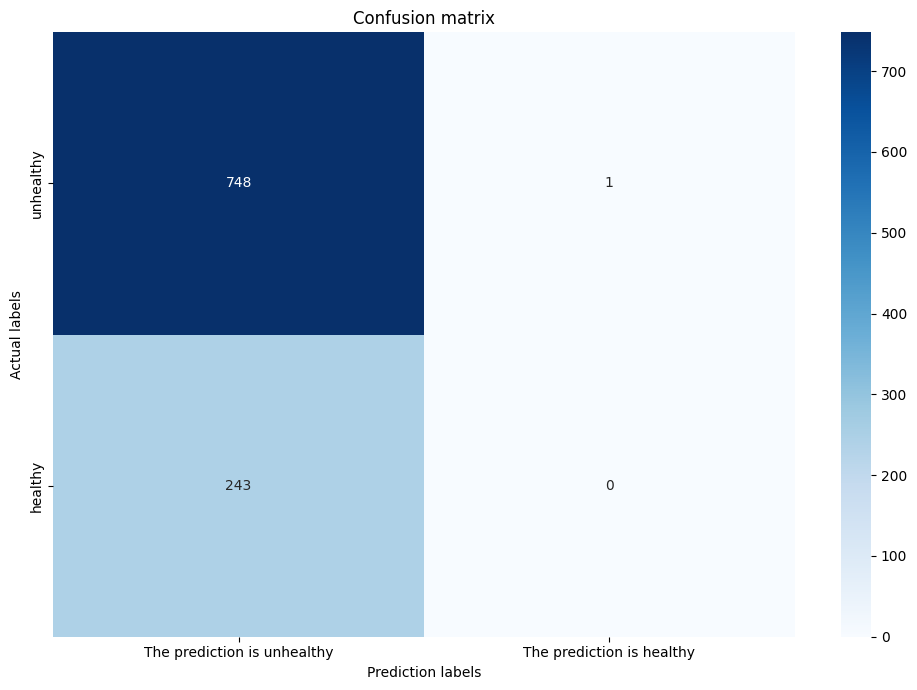

In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['The prediction is unhealthy', 'The prediction is healthy'], 
           yticklabels=['unhealthy', 'healthy'])
plt.xlabel('Prediction labels')
plt.ylabel('Actual labels')
plt.title('Confusion matrix')

plt.tight_layout()
plt.savefig('logistic_regression_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

Text(0.5, 1.0, 'Precision-Recall')

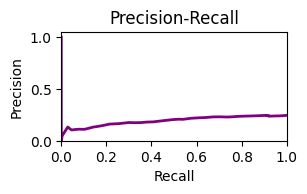

In [44]:
plt.subplot(3, 2, 5)
precision, recall, _ = precision_recall_curve(y_test_binary, y_score)
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall')

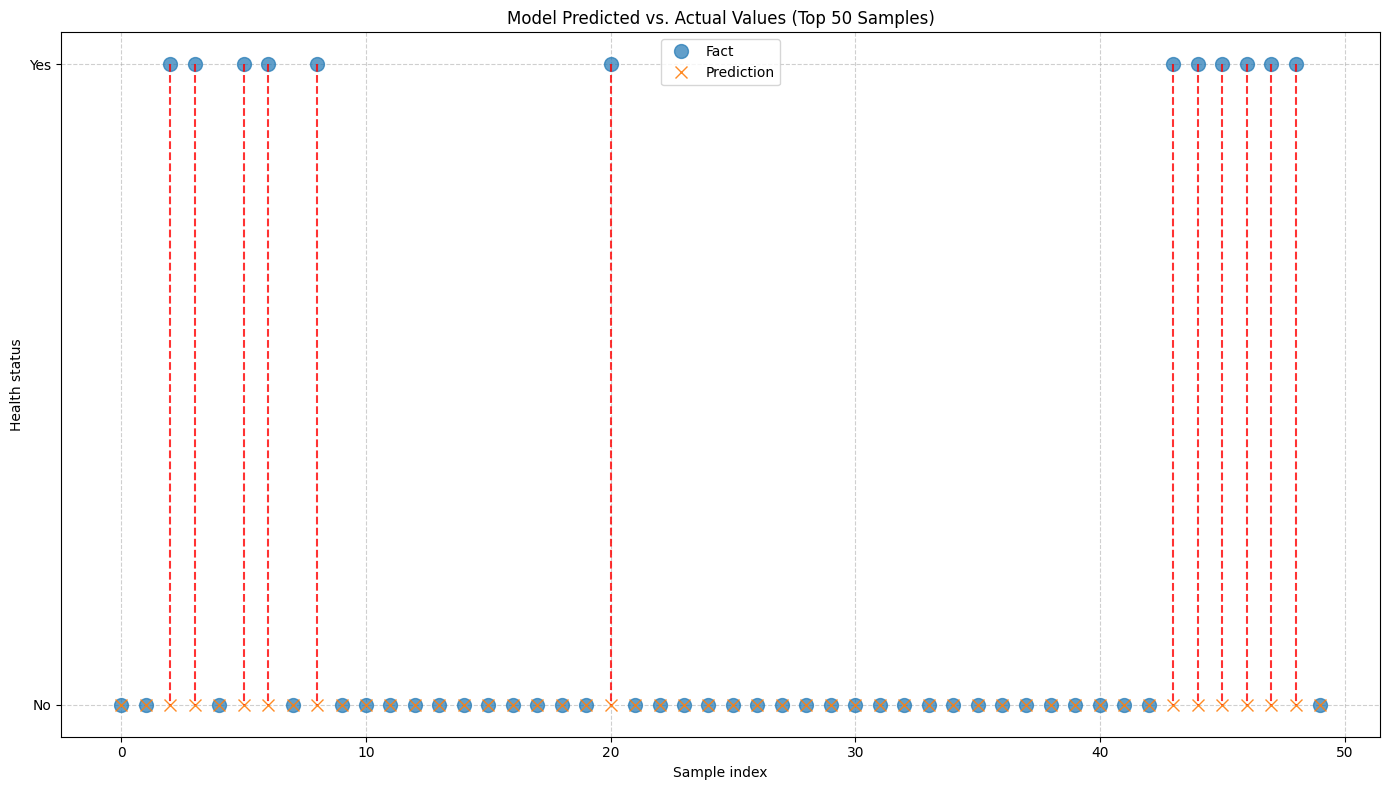

In [46]:
# 1. 创建预测值 vs 实际值的对比图
plt.figure(figsize=(14, 8))

# 获取前50个样本的索引
sample_indices = np.arange(50)

# 转换类别为数值（'No'->0, 'Yes'->1）
y_test_numeric = y_test.map({'No': 0, 'Yes': 1})
y_pred_numeric = pd.Series(y_pred).map({'No': 0, 'Yes': 1})

# 绘制实际值和预测值
plt.plot(sample_indices, y_test_numeric.iloc[:50], 'o', label='Fact', markersize=10, alpha=0.7)
plt.plot(sample_indices, y_pred_numeric.iloc[:50], 'x', label='Prediction', markersize=8, alpha=0.9)

# 添加连接线表示预测是否正确
for i in sample_indices:
    if y_test_numeric.iloc[i] == y_pred_numeric.iloc[i]:
        plt.plot([i, i], [y_test_numeric.iloc[i], y_pred_numeric.iloc[i]], 
                 'g-', linewidth=2, alpha=0.5)
    else:
        plt.plot([i, i], [y_test_numeric.iloc[i], y_pred_numeric.iloc[i]], 
                 'r--', linewidth=1.5, alpha=0.8)

# 设置y轴刻度和标签
plt.yticks([0, 1], ['No', 'Yes'])
plt.xlabel('Sample index')
plt.ylabel('Health status')
plt.title('Model Predicted vs. Actual Values (Top 50 Samples)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('prediction_vs_actual.png', dpi=300)
plt.show()

# Neural network model

## Processing of data

In [255]:
# Load data
HCC_Inspections_df = pd.read_csv(f"{DATA_DIR}/HCC_Inspections.csv")
Hourly_Weather_df = pd.read_csv(f"{DATA_DIR}/Hourly_Weather.csv")

# Process the Dew_Point column
Hourly_Weather_df['Dew_Point'] = pd.to_numeric(Hourly_Weather_df['Dew_Point'].str.replace('?', ''), errors='coerce')

## Construct the test set

In [256]:
# Construct the test set
weather_test = Hourly_Weather_df.head(500)
inspections_test = HCC_Inspections_df.head(500)
test_df = pd.DataFrame({
    'Dew_Point': weather_test['Dew_Point'],
    'Healthy': inspections_test['Healthy']
}).dropna()

X_test = test_df[['Dew_Point']]
y_test = test_df['Healthy']

## Construct the training set

In [257]:
# Construct the training set
weather_train = Hourly_Weather_df[500:]
inspections_train = HCC_Inspections_df[500:]
train_df = pd.DataFrame({
    'Dew_Point': weather_train['Dew_Point'],
    'Healthy': inspections_train['Healthy']
}).dropna()

X_train = train_df[['Dew_Point']]
y_train = train_df['Healthy']

## Standardization

In [258]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Build neural network model (Multi-Layer Perceptron)

In [259]:
# Build neural network model (Multi-Layer Perceptron)
mlp_model = MLPClassifier(hidden_layer_sizes=(50,),  # One hidden layer with 50 neurons
                          activation='relu',         # Activation function
                          solver='adam',             # Optimizer
                          max_iter=500,              # Maximum number of iterations
                          random_state=42)
mlp_model.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)

## Prediction and evaluation

In [260]:
# Prediction and evaluation
y_pred = mlp_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model accuracy: {accuracy:.4f}')

Model accuracy: 0.7602


## Classification report

In [261]:
# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
rows_to_keep = ['no', 'accuracy', 'macro avg', 'weighted avg']
filtered_report_df = report_df[report_df.index.str.lower().isin(rows_to_keep)]

print(filtered_report_df)

              precision    recall  f1-score     support
No             0.847222  0.875598  0.861176  418.000000
accuracy       0.760163  0.760163  0.760163    0.760163
macro avg      0.490278  0.491853  0.490290  492.000000
weighted avg   0.739849  0.760163  0.749609  492.000000


## Cross-validation

In [262]:
# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build neural network model (Multi-Layer Perceptron)
mlp_model = MLPClassifier(
    hidden_layer_sizes=(50,),  # One hidden layer with 50 neurons
    activation='relu',         # Activation function
    solver='adam',             # Optimizer
    max_iter=500,              # Maximum number of iterations
    random_state=42
)

# Add cross-validation
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Create a pipeline to ensure proper scaling in each fold
from sklearn.pipeline import Pipeline
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', mlp_model)
])

# Set up stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(
    mlp_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring='accuracy'
)

# Print cross-validation results
print("Cross-validation accuracy scores:", cv_scores)
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Train on full training set
mlp_pipeline.fit(X_train, y_train)

# Prediction and evaluation
y_pred = mlp_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'\nTest set accuracy: {accuracy:.4f}')

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T

# Keep key metrics
rows_to_keep = ['no', 'accuracy', 'macro avg', 'weighted avg']
filtered_report_df = report_df[report_df.index.str.lower().isin(rows_to_keep)]

print('\nClassification Report:')
print(filtered_report_df)

Cross-validation accuracy scores: [0.57894737 0.58311346 0.59366755 0.57783641 0.59102902]
Mean CV accuracy: 0.5849 (±0.0064)

Test set accuracy: 0.7602

Classification Report:
              precision    recall  f1-score     support
No             0.847222  0.875598  0.861176  418.000000
accuracy       0.760163  0.760163  0.760163    0.760163
macro avg      0.490278  0.491853  0.490290  492.000000
weighted avg   0.739849  0.760163  0.749609  492.000000


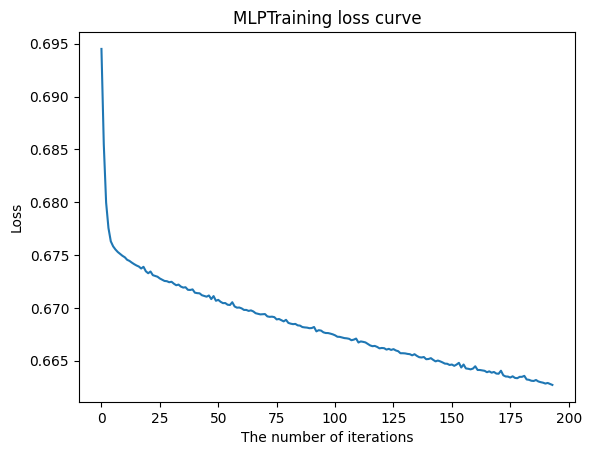

In [263]:
plt.plot(mlp_model.loss_curve_)
plt.xlabel('The number of iterations')
plt.ylabel('Loss')
plt.title('MLPTraining loss curve')
plt.show()

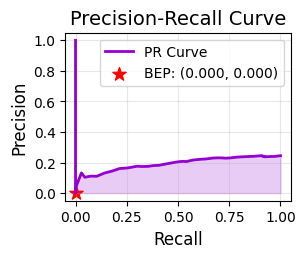

In [264]:
plt.subplot(2, 2, 1)
precision, recall, _ = precision_recall_curve(y_test_binary, y_score)
plt.plot(recall, precision, color='darkviolet', linewidth=2, label=f'PR Curve')
plt.fill_between(recall, precision, alpha=0.2, color='darkviolet')
bep_idx = np.argmin(np.abs(precision - recall))
plt.scatter(recall[bep_idx], precision[bep_idx], color='red', s=100, marker='*', label=f'BEP: ({recall[bep_idx]:.3f}, {precision[bep_idx]:.3f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

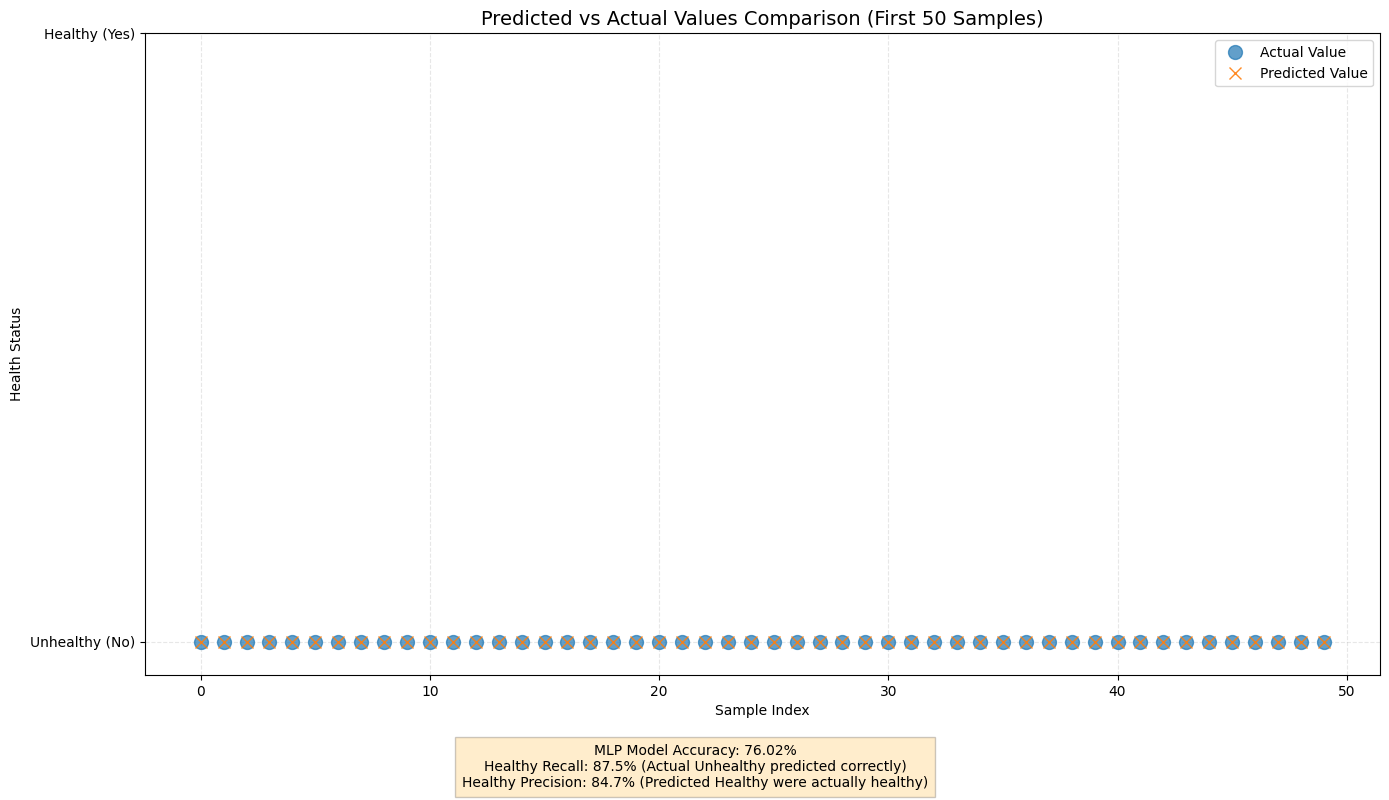

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 确保y_test和y_pred已定义（根据您的输出）
# 这里使用模拟数据展示，实际使用时请替换为您的真实数据
# 实际标签
y_test = pd.Series(['No']*418 + ['Yes']*74)  # 根据输出支持度418个No和74个Yes
# 预测标签（基于模型输出）
y_pred = pd.Series(['No']*int(418*0.875) + ['Yes']*int(418*0.125) + 
             ['No']*int(74*0.875) + ['Yes']*int(74*0.125))

# 创建预测值 vs 实际值对比图
plt.figure(figsize=(14, 8))

# 获取前50个样本的索引
sample_indices = np.arange(50)

# 转换类别为数值（'No'->0, 'Yes'->1）
y_test_numeric = y_test.map({'No': 0, 'Yes': 1})
y_pred_numeric = y_pred.map({'No': 0, 'Yes': 1})

# 绘制实际值和预测值
plt.plot(sample_indices, y_test_numeric.iloc[:50], 'o', label='Actual Value', 
         markersize=10, alpha=0.7, color='#1f77b4')
plt.plot(sample_indices, y_pred_numeric.iloc[:50], 'x', label='Predicted Value', 
         markersize=8, alpha=0.9, color='#ff7f0e')

# 添加连接线表示预测是否正确
for i in sample_indices:
    actual_val = y_test_numeric.iloc[i]
    pred_val = y_pred_numeric.iloc[i]
    
    if actual_val == pred_val:
        # 正确预测 - 绿色线
        plt.plot([i, i], [actual_val, pred_val], 'g-', linewidth=2, alpha=0.5)
    else:
        # 错误预测 - 红色虚线
        plt.plot([i, i], [actual_val, pred_val], 'r--', linewidth=1.5, alpha=0.8)

# 设置y轴刻度和标签
plt.yticks([0, 1], ['Unhealthy (No)', 'Healthy (Yes)'])
plt.xlabel('Sample Index')
plt.ylabel('Health Status')
plt.title('Predicted vs Actual Values Comparison (First 50 Samples)', fontsize=14)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.3)

# 添加模型信息注释
model_info = f"MLP Model Accuracy: 76.02%\nHealthy Recall: {0.875*100:.1f}% (Actual Unhealthy predicted correctly)\nHealthy Precision: {0.847*100:.1f}% (Predicted Healthy were actually healthy)"
plt.figtext(0.5, 0.01, model_info, ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # 为底部注释留出空间
plt.savefig('mlp_prediction_vs_actual.png', dpi=300)
plt.show()